In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%pip install teeplot
from teeplot import teeplot as tp


# OSF identifier
data_id = "98ch3"

# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv(f"https://osf.io/{data_id}/download")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


teeplots/viz=plot-mean-real-execution-time+ext=.pdf
teeplots/viz=plot-mean-real-execution-time+ext=.png


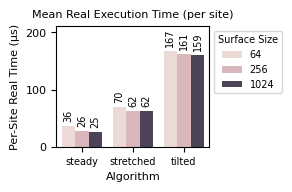

In [2]:
def plot_mean_real_execution_time(data):
    def parse_call(row_str):
        """
        E.g. "steady_lookup_ingest_times_batched(S=64, Tsize=256)"
        -> (algo="steady", S=64, Tsize=256)
        """
        algo = row_str.split("_lookup_ingest_times_batched")[0]
        match = re.search(r"S=(\d+).*Tsize=(\d+)", row_str)
        if not match:
            return algo, None, None
        return algo, int(match.group(1)), int(match.group(2))

    # load into df
    df["algorithm"], df["S"], df["Tsize"] = zip(*df["Call To Function"].map(parse_call))

    # convert to microseconds per site
    df["Real Time Per Site (µs)"] = (df["Real Execution Time"] * 1e6) / df["S"]

    # Group by algorithm, S and compute mean per-site time
    grouped = df.groupby(["algorithm", "S"], as_index=False)["Real Time Per Site (µs)"].mean()

    # bar plot
    plt.figure(figsize=(3, 2))  # these are IRL dimensions

    # more bar plot
    ax = sns.barplot(data=grouped, x="algorithm", y="Real Time Per Site (µs)", hue="S", alpha=0.85)

    # add labels to the bars
    for container in ax.containers:
        labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in container]
        rotation = 90 if any(label > 150 for label in labels) else 0  # rotate for large values, they clip otherwise
        ax.bar_label(container, labels=labels, fmt='%d', fontsize=7, padding=3, rotation=rotation)

    # better readability
    plt.title("Mean Real Execution Time (per site)", fontsize=8)
    plt.xlabel("Algorithm", fontsize=8)
    plt.ylabel("Per-Site Real Time (µs)", fontsize=8)

    # rotate x-axis labels
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=8)

    # ylim
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)

    # legend
    plt.legend(title="Surface Size", title_fontsize=7, fontsize=7, loc="upper left", bbox_to_anchor=(1, 1))

    # layout adjustment
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout(pad=1)


# teeplot
tp.tee(plot_mean_real_execution_time, data=df)
